# Testing Environment for Times.py file
Shaun Hadden & Brendan Smithyman | October, 2015

## Imports

In [1]:
import sys
sys.path.append('../')
import numpy as np
from anemoi import Eurus, StackedSimpleSource

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import matplotlib.animation as animation
import math
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

## Helper functions

In [3]:
class Source(object):
    
    def __init__(self, sc):
                
        self._x, self._z = np.mgrid[
            0:sc['dx']*sc['nx']:sc['dx'],
            0:sc['dz']*sc['nz']:sc['dz']
        ]
    
    def __call__(self, x, z):
        
        dist = np.sqrt((self._x - x)**2 + (self._z - z)**2)
        srcterm = 1.*(dist == dist.min())
        nz, nx = self._x.shape
        
        return np.hstack([srcterm.T.ravel() / srcterm.sum(), np.zeros(nx*nz, dtype=np.complex128)])

## Modelling setup

In [4]:
# Geometry parameters
dx          = 1.
dz          = 1.
nx          = 100
nz          = 200

# Bulk parameters
velReal     = 2000.     * np.ones((nz,nx))
density     = 1.        * np.ones((nz,nx))

Q           = 10000.
velImag     = ((-1 * velReal) * 2)/Q

velocity    = velReal + (1j * velImag)
# Anisotropy parameters
theta       = 0.        * np.ones((nz,nx))
epsilon     = 0.        * np.ones((nz,nx))
delta       = 0.        * np.ones((nz,nx))

# Other parameters
freq        = 400.
freeSurf    = [False, False, False, False]
nPML        = 10
fDamp       = 0.4
# Source and Modelling Parameters

#fMax       = 4. 
sourceFreq = 128
nTSamp = 256

#   determine the maximum length of the Model
xMax = (nx-1) * dx
zMax = (nz-1) * dz
LMax = np.max([xMax,zMax])

cMin = velocity.min()

#calculate the smallest wavelength, in meters
#lambdaMin = cMin / fMax

 #   determine the maximum modelled time from the maximum length of the grid
#   and the minimum velocity



#time-domain damping factor



#determine the number of frequencies

#nf = 3
#df = 1
#   determine the sampling interval and number of time domain samples

#dt = 1 / (2 * fMax)
dt = 0.002

#nt = tMax / dt

tMax = dt * nTSamp

#tMax = 3 * (LMax / cMin.real)

tau = fDamp * tMax

#   determine the frequency interval from the maximum modelled time

df= 1 / tMax

fMax = 1 / dt
nf = int(fMax / df)
fMin = fMax - ((nf - 1) * df)


freqRange = np.arange(fMin,fMax + df,df)

# Pack values into systemConfig dictionary
systemConfig = {
    'nx':       nx,
    'nz':       nz,
    'dx':       dx,
    'dz':       dz,

    'c':        velocity,
    'rho':      density,
    
    'theta':    theta,
    'eps':      epsilon,
    'delta':    delta,

    'freq':     freqRange[0],
    'freeSurf': freeSurf,
    'nPML':     nPML,
    'cPML':     1e3,
    
    'tau':      tau,
    'f_max':    fMax, 
    'source_freq': sourceFreq,
    'nt':       nTSamp,
    'nf':       nf,
    'df':       df,
    'nf':       nf,
}

## Testing

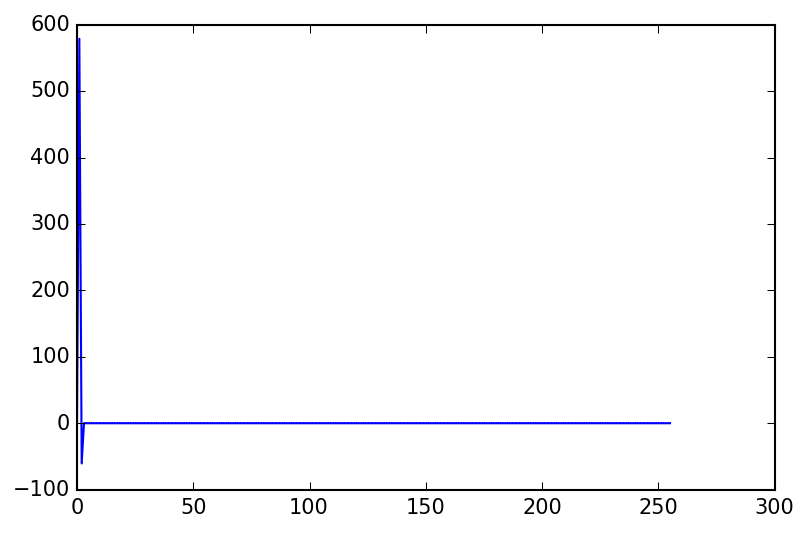

In [5]:
excursions=1
#keuper wavelet
m = (excursions + 2) / excursions
nsrc = int((1. / sourceFreq) / dt)
delta = excursions * np.pi * sourceFreq
#loopVals = np.arange(1,nsrc + 1,1)
tsrc = np.zeros(nsrc)
tempSource = np.zeros(nsrc)

for i in range(1,nsrc+1):

    tsrc[i-1] = (i - 1.) * dt
    tempSource[i-1] = (delta * np.cos(delta *tsrc[i-1])) - (delta *np.cos(m * delta *tsrc[i-1]))
            


timeSource = np.zeros(nTSamp)
timeSource[:len(tempSource)] = tempSource[:]

plt.plot(timeSource, markersize=0.1, marker=',')

freqSource=np.fft.fft(np.asarray(timeSource))
freqSource[-((nTSamp / 2) + 1):]=0

#plt.plot(freqSource.real, markersize=0.1, marker=',')

In [6]:
uP = np.zeros((nf,nz,nx),dtype=np.complex128)
for i in range(1,len(freqRange)):
    
    if (freqRange[i-1] <= sourceFreq):
        systemConfig['freq'] = freqRange[i-1]
        Ainv = Eurus(systemConfig)
        src = StackedSimpleSource(systemConfig)
        q = src(50,100)
        uP[i-1] = (Ainv* (q * (-1 * freqSource[i])))[:nx*nz].reshape((nz,nx))
    else:
        break


In [160]:
tempFreq = np.zeros((math.ceil(nTSamp/2)+1,nz,nx),dtype=np.complex128)
istart   = 1
iend   = math.ceil(nTSamp/2)
tempFreq[istart:iend+2,:,:] = uP[:iend]
#tempFreq[iend+1:nTSamp+2,:,:] =np.flipud(uP[:iend]).conjugate()
#tempFreq[iend+1:nTSamp+2,:,:] =0
uT = np.zeros((math.ceil(nTSamp/2)+1,nz,nx),dtype=np.complex128)

#uP_conj = uP.conjugate()    
uT = np.fft.ifft(tempFreq.conjugate(),axis=0)
print uT.shape
#ut  = uT.reshape(-1,nz,xz)

(129, 200, 100)


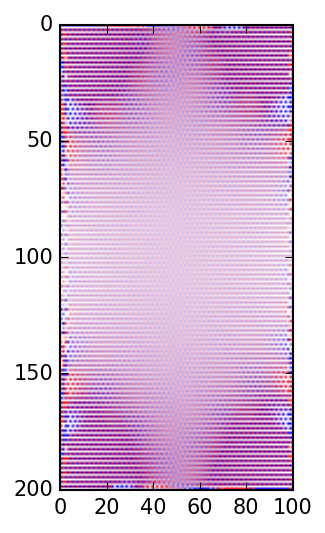

In [8]:
clip = 2e-2
fig  = plt.figure()
#ax = fig.add_subplot(1,1,1, aspect=1)
plotopts = {
    'extent':   [0, nx*dx, nz*dz, 0],
    'cmap':     cm.bwr,
    'vmin':     -clip,
    'vmax':     clip,
}
im   = plt.imshow(uT[0].reshape((nz,nx)).real, **plotopts)
#im   = plt.imshow(uT[0].reshape((nz,nx)).real)

def updatefig(j):
    
    im.set_array(uT[j].reshape((nz,nx)).real)
    return im,

ani = animation.FuncAnimation(fig, updatefig)
#fig = plt.figure(figsize=(8,6), dpi=160)
#ani.save()

#plt.imshow(uT[200].reshape((nz,nx)).real, **plotopts)
#plt.title('Real Wavefield')
#plt.xlabel('X')
#plt.ylabel('Z')
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x7fbbc802d248>

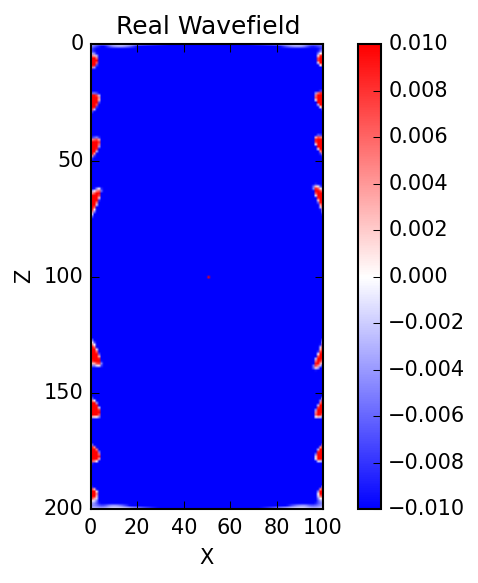

In [166]:
clip = 1e-2

plotopts = {
    'extent':   [0, nx*dx, nz*dz, 0],
    'cmap':     cm.bwr,
    'vmin':     -clip,
    'vmax':     clip,
}


plt.imshow(uT[122].reshape((nz,nx)).real, **plotopts)
plt.title('Real Wavefield')
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()

In [10]:
Ainv = Eurus(systemConfig)
#src = Source(systemConfig)
src = StackedSimpleSource(systemConfig)

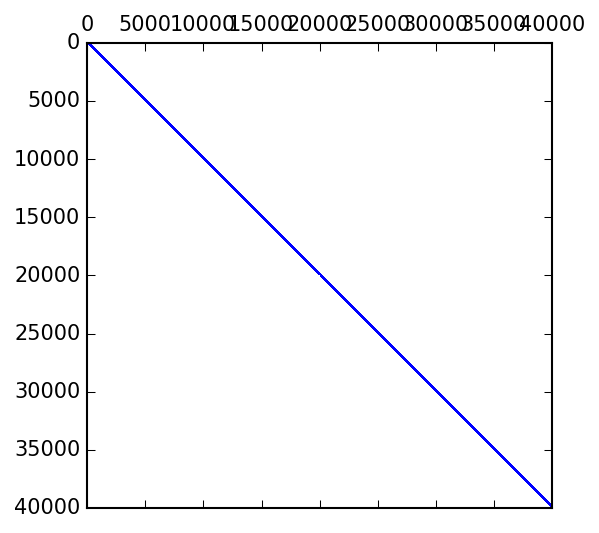

In [11]:
plt.spy(Ainv.A, markersize=0.1, marker=',')

In [12]:
q = src(50,100)
u = Ainv*q

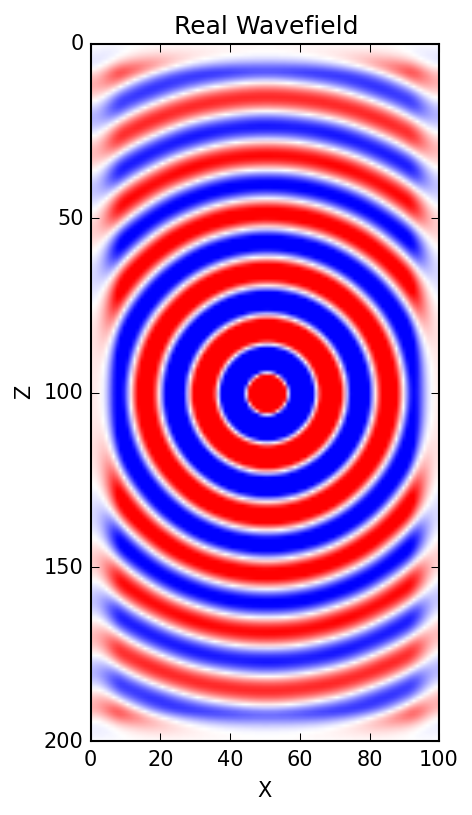

In [13]:
clip = 2e1

plotopts = {
    'extent':   [0, nx*dx, nz*dz, 0],
    'cmap':     cm.bwr,
    'vmin':     -clip,
    'vmax':     clip,
}

fig = plt.figure(figsize=(8,6), dpi=160)

ax = fig.add_subplot(1,1,1, aspect=1)
plt.imshow(uP[60].reshape((nz,nx)).real, **plotopts)
plt.title('Real Wavefield')
plt.xlabel('X')
plt.ylabel('Z')

In [148]:
print nf
print df
print fMax
print sourceFreq
print dt

256
1.953125
500.0
128
0.002
